In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import yfinance as yf
import time
import datetime as dt

# 01. Loading the stock

* N_STEPS: number of days for window → `depth`/ `length` of input sequence which the neural network will process  
* LOOKUP_STEPS: array which includes the number and sequence of days for the prediction:
    * array `[1, 2, 3]` represents a forecast for three days:  
        * 1: tomorrow
        * 2: the day after tomorrow
        * 3: the day after the second day  
* STOCK: ticker-symbol/unique code of letters assigned to a publicly traded company's stock (GOOGL the ticker on NASDAQ). 

In [2]:
N_STEPS = 7
STOCK_g = 'GOOGL'
STOCK_a = 'AAPL'

date_now = time.strftime('%Y-%m-%d')
date_2years_ago = (dt.date.today() - dt.timedelta(days=730)).strftime('%Y-%m-%d')
date_3years_ago = (dt.date.today() - dt.timedelta(days=1095)).strftime('%Y-%m-%d')

print(date_now
     )

2024-02-15


In [3]:
# loading the apple and google stocks
stock_google = yf.download(STOCK_g,
                           start=date_3years_ago,
                           end=date_now,
                           interval='1d')

stock_apple = yf.download(STOCK_a, 
                          start=date_2years_ago,
                          end=date_now,
                          interval='1d')

# remove ne unnecessary columns → only focus on 'Close' (displays the price on the closing market that day)
close_apple = stock_apple.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

close_google = stock_google.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# reset the index and rename the 'Close' columns
close_apple = close_apple.reset_index()
close_apple.rename(columns={'Close':'Apple_close'}, 
                   inplace=True)

close_google = close_google.reset_index()
close_google.rename(columns={'Close':'Google_close'}, 
                    inplace=True)   # allows to apply to changes to the initial df

# print the resulting columns
print(close_apple.head(5))
print()
print(close_google.head(5))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

        Date  Apple_close
0 2022-02-15   172.789993
1 2022-02-16   172.550003
2 2022-02-17   168.880005
3 2022-02-18   167.300003
4 2022-02-22   164.320007

        Date  Google_close
0 2021-02-16    105.535004
1 2021-02-17    105.931000
2 2021-02-18    105.290497
3 2021-02-19    104.440498
4 2021-02-22    102.712997


# 02. Displaying the data

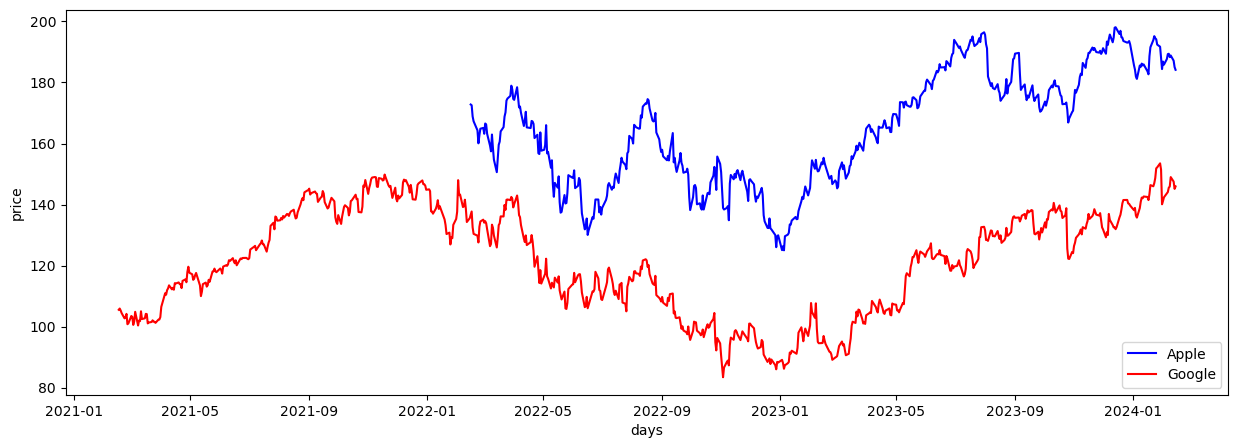

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(close_apple['Date'], close_apple['Apple_close'], color='blue', label='Apple')
plt.plot(close_google['Date'], close_google['Google_close'], color='red', label='Google')
plt.xlabel('days')
plt.ylabel('price')
plt.legend(loc="lower right")
plt.show()

# 03. Normalizing the Data

When working with multiple time series data, such as stock prices for different stocks, it's common practice to normalize each time series separately rather than together. 

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
close_apple['Apple_close'].shape

(502,)

In [7]:
def reshaper_2d(col):
    col = col.values.reshape((-1, 1))
    return col

for the `MinMaxScaler()` we need the a 2 dimensional array, therefore the shape needs first to be readjusted

In [8]:
scaler_apple = MinMaxScaler()
scaler_google = MinMaxScaler()

apple_np = reshaper_2d(close_apple['Apple_close'])
google_np = reshaper_2d(close_google['Google_close'])

close_apple_rescaled = close_apple.copy()
close_google_rescaled = close_google.copy()

close_apple_rescaled['Apple_close'] = scaler_apple.fit_transform(apple_np)
close_google_rescaled['Google_close'] = scaler_google.fit_transform(google_np)

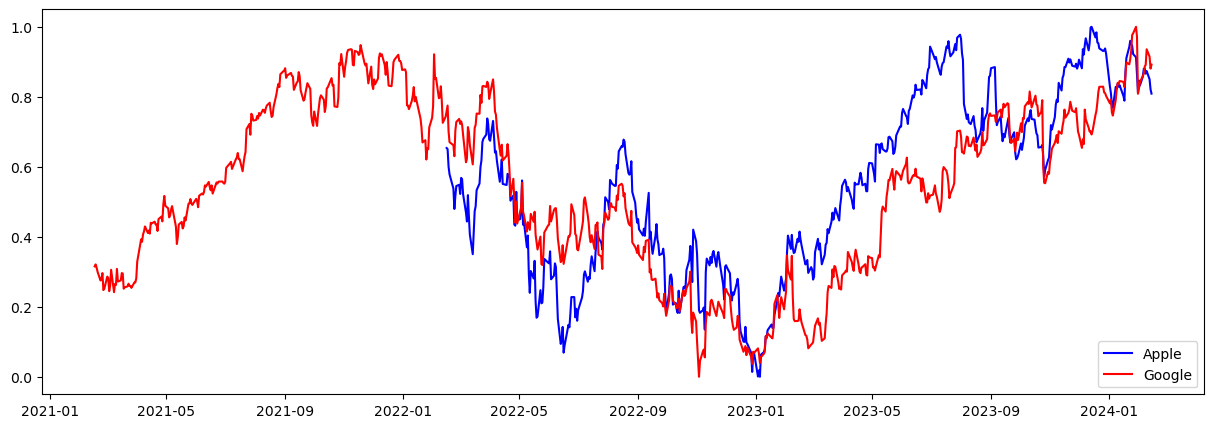

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(close_apple_rescaled['Date'], close_apple_rescaled['Apple_close'], color='blue', label='Apple')
plt.plot(close_google_rescaled['Date'], close_google_rescaled['Google_close'], color='red', label='Google')
plt.legend(loc="lower right")
plt.show()

# 04. Preparation of the data for the engine

In order to being able to train a model an stock prizes, we need to bring the data in an acceptable format:  
* 7 `Timesteps` → list of lists, where each sublist entails 7 censequtive stock prices (1 `Feature`)  
* for each sublist we need a `Label` (Future), in this case the prediction in #'LOOKUP_STEPS' days  

<img src="./data_preparation.png" width="500"/>

In [10]:
from collections import deque                             # double ended queue, elements can be added and removed efficiently form both ends

In [11]:
def PrepareData(initial_df, days):
    df = initial_df.copy()
    df['Future'] = df.iloc[:, 1].shift(-days)             # creates a new column & shifts the 'close'-column #'DAYS' rows up → at the bootom of the 'future'-column will be #'DAYS' NaNs
    last_sequence = np.array(df.iloc[:, 1].tail(days))       # returns the last #days from the 'close'-column
    df.dropna(inplace=True)                               # removes the last #days rows of the df
  
    sequence_data = list()
    sequences = deque(maxlen=N_STEPS)                     # deque-object is created with the maximum length of 7
                                                                # after it reaches its `maxlen` it removes it's 1. item and adds the new one at the 7. place

    for entry, target in zip(df.iloc[:, [1, 0]].values,  # selects the columns 'X_close' & 'Date'
                             df['Future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:                               # after 'seqnces' reached length of 7
            sequence_data.append([np.array(sequences), target])         # 'close' & 'date' (=sequnce) + target (=close #'DAYS' rows up) 

    # last sequence
    last_sequence = list([seq[0] for seq in sequences]) + list(last_sequence)   # selects all 'close' entries from 'sequences'-'entry'
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X = list()
    y = list()
    for seq, target in sequence_data:
        X.append(seq)             # 'df[['X_close'] + ['Date']]'
        y.append(target)          # 'Future'-values

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return df, last_sequence, X, y

* df['Date', 'X_close', 'Future']  
* last_sequence: 'Close_values' for the entries without the last #'DAYS' + entries  for the last #'DAYS'  
* X: list of lists containing 7 seqences (moving one at a time)
* y: prdicted Value #'DAYS' days prior

# 05. CNN

In [12]:
def GetTrainedModel(X_train, y_train):
    model = tf.keras.Sequential([
          tf.keras.layers.LSTM(units=60,
                              return_sequences=True,
                              input_shape=(N_STEPS, 1)),     # 7 time steps (consequitive days), 1 feature (closing price)
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.LSTM(units=120, return_sequences=False),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Dense(units=20),
          tf.keras.layers.Dense(units=1)  
      ])

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])

    model.fit(X_train, y_train,
              batch_size=8,
              epochs=80, 
              verbose=0)

    return model


<img src="./stock_3days.png" width="500"/>

In [13]:
# GET PREDICTIONS

def predict_future(df_name, scaler, LOOKUP_STEPS, predictions):
    
    for step in LOOKUP_STEPS:
        df, last_sequence, X_train, y_train = PrepareData(df_name, step)
        X_train = X_train[:, :, 0].astype(np.float32).reshape(-1, 7, 1)

        model = GetTrainedModel(X_train, y_train)

        last_sequence = last_sequence[-N_STEPS:]     # takes the last seqence with #'N_STEPS' which will be used for a prediction #'LOOKUP_STEPS' from today
        last_sequence = last_sequence.reshape((-1, 1))  # shape: (7, 1)
        prediction = model.predict(last_sequence)
        predicted_price = scaler.inverse_transform(prediction)[0][0]

        predictions.append(round(float(predicted_price), 2))
        
    return predictions

In [ ]:
LOOKUP_STEPS = [1, 2, 3]
predictions_apple = list()
predictions_google = list()

predictions_apple = predict_future(close_apple_rescaled, scaler_apple, LOOKUP_STEPS, predictions_apple)
predictions_google = predict_future(close_google_rescaled, scaler_google, LOOKUP_STEPS, predictions_google)

In [ ]:
LOOKUP_STEPS = [4, 5, 6]

predictions_apple = predict_future(close_apple_rescaled, scaler_apple, LOOKUP_STEPS, predictions_apple)
predictions_google = predict_future(close_google_rescaled, scaler_google, LOOKUP_STEPS, predictions_google)

In [ ]:
LOOKUP_STEPS = [7, 8, 9]

predictions_apple = predict_future(close_apple_rescaled, scaler_apple, LOOKUP_STEPS, predictions_apple)
predictions_google = predict_future(close_google_rescaled, scaler_google, LOOKUP_STEPS, predictions_google)

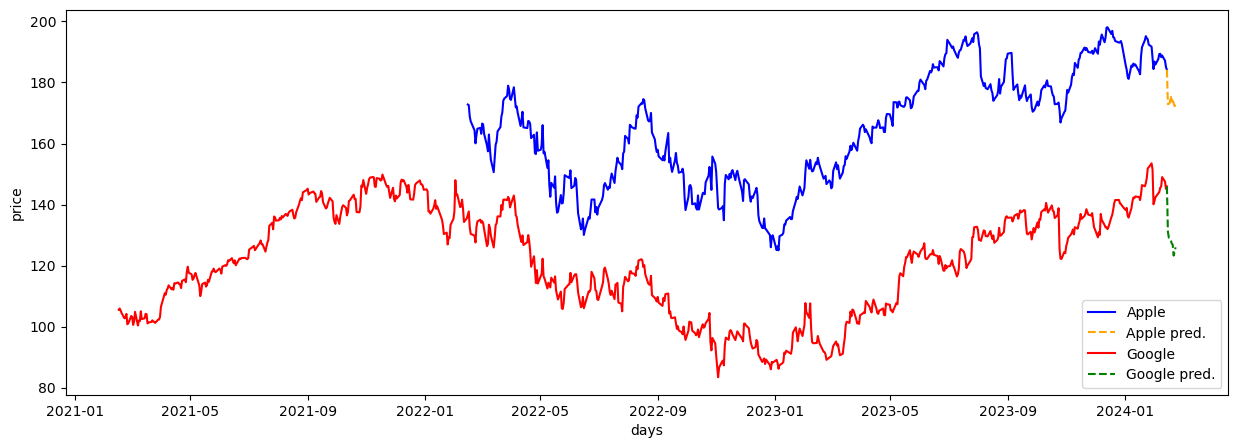

In [29]:
today = dt.date.today()

# list with days from yesterday to after tomorrow
upcoming_days = [(today + dt.timedelta(days=i)) for i in range(-1, 9)]

# adding the yesterdays price on the closing market to the prediction lists
predictions_apple.insert(0, close_apple['Apple_close'].iloc[-1])
predictions_google.insert(0, close_google['Google_close'].iloc[-1])


plt.figure(figsize=(15, 5))
plt.plot(close_apple['Date'], close_apple['Apple_close'], color='blue', label='Apple')
plt.plot(upcoming_days, predictions_apple, color='orange', label='Apple pred.', linestyle='dashed')
plt.plot(close_google['Date'], close_google['Google_close'], color='red', label='Google')
plt.plot(upcoming_days, predictions_google, color='green', label='Google pred.', linestyle='dashed')
plt.xlabel('days')
plt.ylabel('price')
plt.legend(loc="lower right")
plt.show()